<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [0]:
### YOUR CODE STARTS HERE

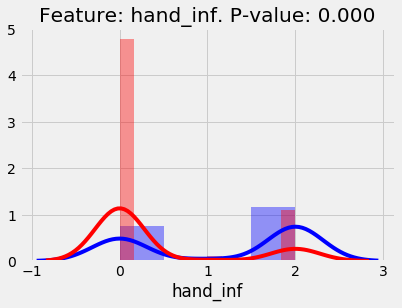

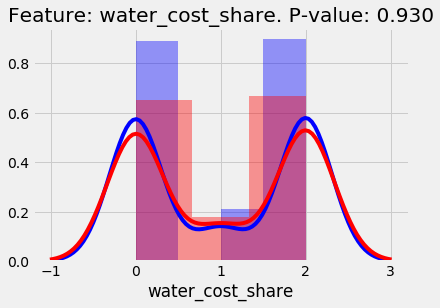

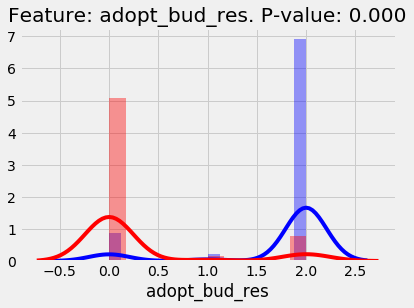

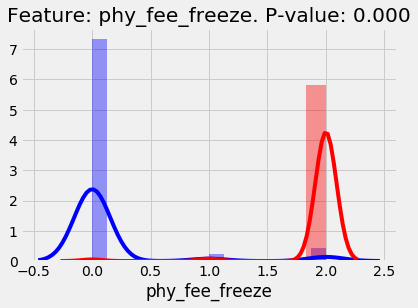

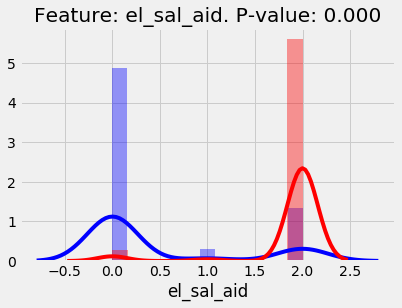

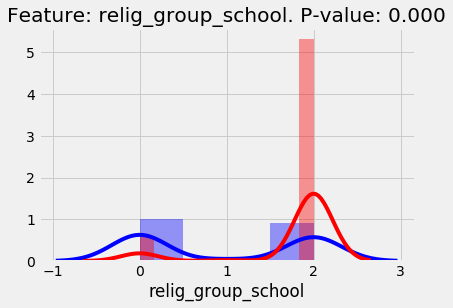

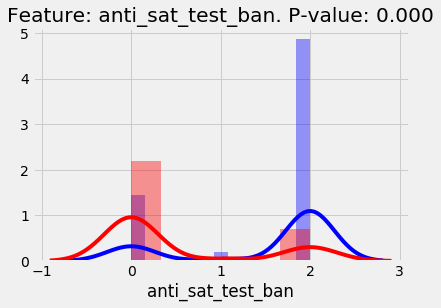

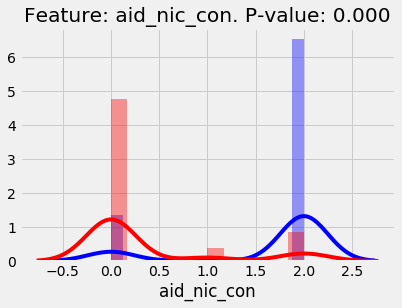

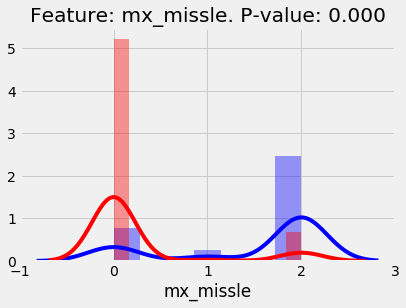

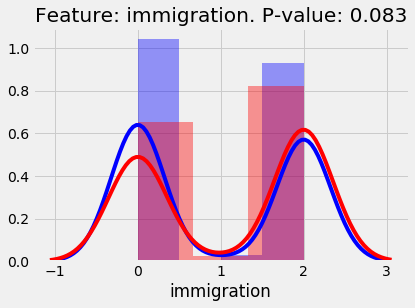

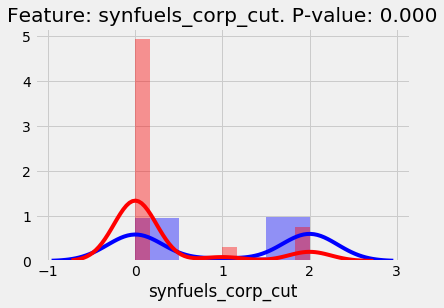

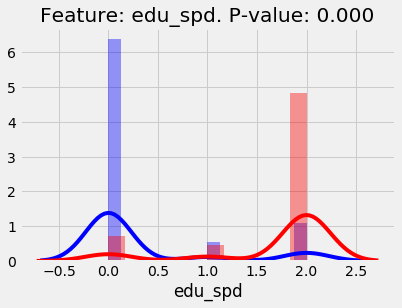

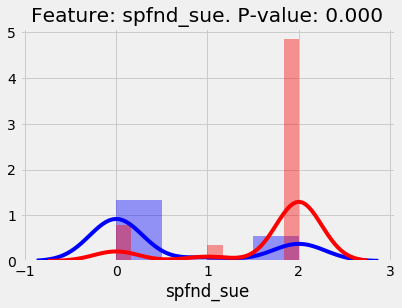

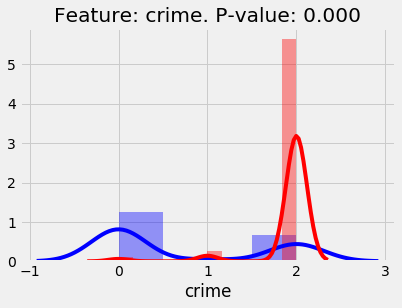

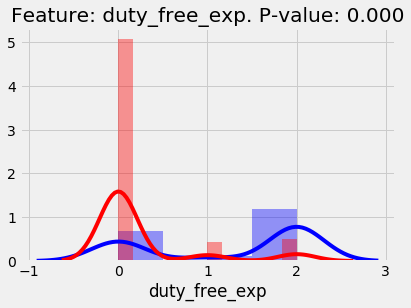

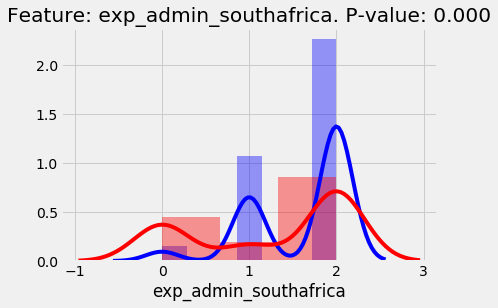

<Figure size 432x288 with 0 Axes>

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

style.use('fivethirtyeight')

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

col_names = ['affiliation', 'hand_inf', 'water_cost_share', 'adopt_bud_res',
            'phy_fee_freeze', 'el_sal_aid', 'relig_group_school', 
            'anti_sat_test_ban', 'aid_nic_con', 'mx_missle', 'immigration',
            'synfuels_corp_cut', 'edu_spd', 'spfnd_sue', 'crime', 
             'duty_free_exp', 'exp_admin_southafrica']

df = pd.read_csv(data_url, names = col_names, header = None, na_values = '?')
df = df.fillna(1)
df = df.replace(('y', 'n'), (2, 0))

for column in df.loc[:, df.columns != 'affiliation']:
  group1 = df[df['affiliation'] == 'democrat'][column]
  group2 = df[df['affiliation'] == 'republican'][column]
  sns.distplot(group1, color = 'blue')
  sns.distplot(group2, color = 'red')
  _, pvalue = ttest_ind(group1, group2)
  plt.title(f'Feature: {column}. P-value: {pvalue:.3f}')
  plt.figure()



Supported by Dems


*   Handicapped Infants
*   Adoption of Budget Resolution
*   Anti-Satellite Test Ban
*   Aid to Nicaraguan Contras
*   Mx Missile
*   Synfuels Corporation Cutback
*   Duty Free Exports
*   Export Administration Act South Africa

Supported by Repubs
*   Physician Fee Freeze
*   El Salvador Aid
*   Religious Groups in Schools
*   Education Spending
*   Superfund Right to Sue
*   Crime

Both Support
*   Water Project Cost Sharing
*   Immigration

